## Week 1: Using CNN's with the Cats vs Dogs Dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import random
import os

from tensorflow.keras import layers, losses

In [2]:
from_scratch = False

In [3]:
dataset_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
dataset_file = tf.keras.utils.get_file(origin=dataset_url, extract=True if from_scratch else False)
data_path = os.path.dirname(dataset_file)

In [4]:
source_path = os.path.join(data_path, 'PetImages')
source_path_cats = os.path.join(source_path, 'Cat')
source_path_dogs = os.path.join(source_path, 'Dog')

#### Data cleaning

In [5]:
file1_path = os.path.join(source_path_cats, 'Thumbs.db')
file2_path = os.path.join(source_path_dogs, 'Thumbs.db')

if os.path.exists(file1_path):
    os.remove(file1_path)

if os.path.exists(file2_path):
    os.remove(file2_path)

In [6]:
print(f'There are {len(os.listdir(source_path_dogs))} images of dogs')
print(f'There are {len(os.listdir(source_path_cats))} images of cats')

There are 12500 images of dogs
There are 12500 images of cats


In [7]:
root_dir = os.path.join(data_path, 'cats-v-dogs')

training_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

training_cats_dir = os.path.join(training_dir, 'cats')
training_dogs_dir = os.path.join(training_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [8]:
if from_scratch:
    if os.path.exists(root_dir):
        shutil.rmtree(root_dir)

    def create_train_val_dirs(root_path):
        os.makedirs(training_cats_dir)
        os.makedirs(training_dogs_dir)
        os.makedirs(validation_cats_dir)
        os.makedirs(validation_dogs_dir)

    create_train_val_dirs(root_dir)

In [9]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

C:\Users\Eduardo\.keras\datasets\cats-v-dogs\training
C:\Users\Eduardo\.keras\datasets\cats-v-dogs\validation
C:\Users\Eduardo\.keras\datasets\cats-v-dogs\training\cats
C:\Users\Eduardo\.keras\datasets\cats-v-dogs\training\dogs
C:\Users\Eduardo\.keras\datasets\cats-v-dogs\validation\cats
C:\Users\Eduardo\.keras\datasets\cats-v-dogs\validation\dogs


In [10]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    source_files = []

    for image_name in os.listdir(SOURCE_DIR):
        image_path = os.path.join(SOURCE_DIR, image_name)
        try:
            img_bytes = tf.io.read_file(image_path)
            decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
            print(f'Found bad path {image_path}')
            continue

        source_files.append(image_name)

    num_images = len(source_files)
    num_training = int(num_images * SPLIT_SIZE)
    list_files = random.sample(source_files, num_images)
    training_images = list_files[:num_training]
    validation_images = list_files[num_training:]

    for training_image in training_images:
        shutil.copyfile(os.path.join(SOURCE_DIR, training_image), os.path.join(TRAINING_DIR, training_image))

    for validation_image in validation_images:
        shutil.copyfile(os.path.join(SOURCE_DIR, validation_image), os.path.join(VALIDATION_DIR, validation_image))

In [11]:
if from_scratch:
    # Empty directories in case you run this cell multiple times
    if len(os.listdir(training_cats_dir)) > 0:
        for file in os.scandir(training_cats_dir):
            os.remove(file.path)
    if len(os.listdir(training_dogs_dir)) > 0:
        for file in os.scandir(training_dogs_dir):
            os.remove(file.path)
    if len(os.listdir(validation_cats_dir)) > 0:
        for file in os.scandir(validation_cats_dir):
            os.remove(file.path)
    if len(os.listdir(validation_dogs_dir)) > 0:
        for file in os.scandir(validation_dogs_dir):
            os.remove(file.path)

    # Define proportion of images used for training
    split_size = .9

    # NOTE: Messages about zero length images should be printed out
    split_data(source_path_cats, training_cats_dir, validation_cats_dir, split_size)
    split_data(source_path_dogs, training_dogs_dir, validation_dogs_dir, split_size)

In [12]:
# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"Original cat's directory has {len(os.listdir(source_path_cats))} images")
print(f"Original dog's directory has {len(os.listdir(source_path_dogs))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(training_cats_dir))} images of cats for training")
print(f"There are {len(os.listdir(training_dogs_dir))} images of dogs for training")
print(f"There are {len(os.listdir(validation_cats_dir))} images of cats for validation")
print(f"There are {len(os.listdir(validation_dogs_dir))} images of dogs for validation")

Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11247 images of cats for training
There are 11244 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    label_mode='binary',
    batch_size=128,
    image_size=(150, 150)
).cache().prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='binary',
    batch_size=32,
    image_size=(150, 150)
).cache().prefetch(tf.data.AUTOTUNE)

Found 22491 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.


#### Configure the dataset for performance

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.8:
            print('\nReached 95% accuracy and 80% validation accuracy so cancelling training')
            self.model.stop_training = True

In [16]:
def create_model():

    model = tf.keras.Sequential([ 
        layers.Rescaling(1/255, input_shape=(150, 150, 3)),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1)])

    model.compile(optimizer='rmsprop',
                  loss=losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy']) 

    return model

In [17]:
model = create_model()

callbacks = myCallback()

history = model.fit(train_dataset,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_dataset,
                    callbacks=[callbacks])

Epoch 1/15
176/176 [==============================] - 27s 135ms/step - loss: 0.6976 - accuracy: 0.5913 - val_loss: 0.5505 - val_accuracy: 0.7004
Epoch 2/15
176/176 [==============================] - 25s 139ms/step - loss: 0.5437 - accuracy: 0.7101 - val_loss: 0.5492 - val_accuracy: 0.6604
Epoch 3/15
176/176 [==============================] - 15s 85ms/step - loss: 0.4612 - accuracy: 0.7724 - val_loss: 0.4540 - val_accuracy: 0.7944
Epoch 4/15
176/176 [==============================] - 15s 85ms/step - loss: 0.3998 - accuracy: 0.8064 - val_loss: 0.4770 - val_accuracy: 0.7784
Epoch 5/15
176/176 [==============================] - 15s 86ms/step - loss: 0.3433 - accuracy: 0.8416 - val_loss: 0.4583 - val_accuracy: 0.7748
Epoch 6/15
176/176 [==============================] - 15s 86ms/step - loss: 0.2889 - accuracy: 0.8711 - val_loss: 0.4703 - val_accuracy: 0.7956
Epoch 7/15
176/176 [==============================] - 15s 86ms/step - loss: 0.2196 - accuracy: 0.9060 - val_loss: 0.5063 - val_accurac

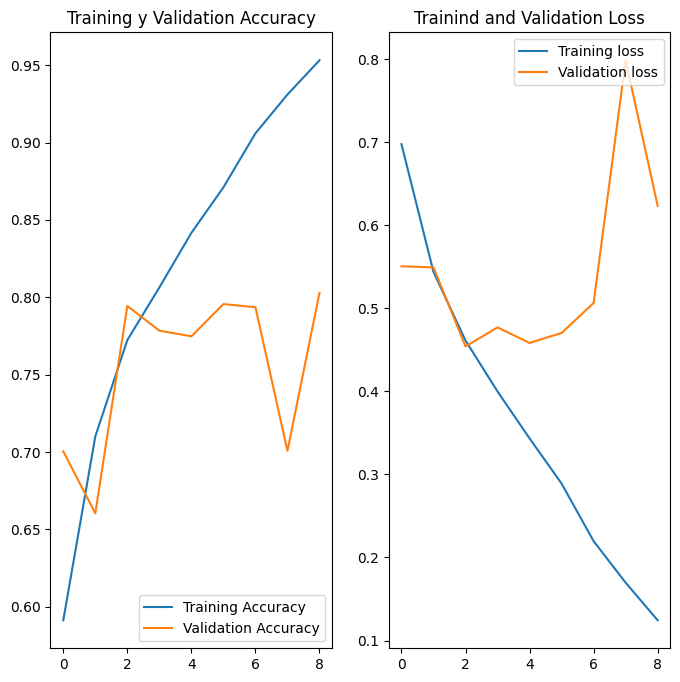

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()